In [45]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from v1t.utils import utils, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()
IMAGE_SIZE = (1, 36, 64)

In [46]:
def load_results(filename: str):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    return results


cnn_results = load_results("../runs/sensorium/023_stacked2d_gaussian2d_bm0/aRFs.pkl")
vit_results = load_results("../runs/sensorium/026_vit_gaussian2d_bm0/aRFs.pkl")

### Plot aRF and 2D Gaussian fit of 6 random artificial units

In [47]:
random_units = np.random.choice(cnn_results["aRFs"].shape[0], size=6, replace=False)

In [103]:
normalize = lambda a: (a - a.min()) / (a.max() - a.min())


def Gaussian2d(
    xy: np.ndarray,
    amplitude: float,
    xo: float,
    yo: float,
    sigma_x: float,
    sigma_y: float,
    theta: float,
    offset: float,
):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()


def plot_aRFs(
    aRFs: np.ndarray,
    parameters: np.ndarray = None,
    title: str = None,
    filename: str = None,
):
    height, width = aRFs.shape[2], aRFs.shape[3]
    x, y = np.linspace(0, width, width), np.linspace(0, height, height)
    x, y = np.meshgrid(x, y)

    nrows, ncols = 2, 3
    tick_fontsize, label_fontsize, title_fontsize = 8, 9, 10
    figure, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        gridspec_kw={"wspace": 0.02, "hspace": 0.2},
        figsize=(6, 2.6),
        dpi=180,
    )
    axes = axes.flatten()

    for i, unit in enumerate(random_units):
        axes[i].imshow(normalize(aRFs[unit][0]), cmap="gray", vmin=0, vmax=1)
        if parameters is not None:
            fitted = Gaussian2d((x, y), *parameters[unit])
            fitted = fitted.reshape(height, width)
            axes[i].contour(
                x,
                y,
                fitted,
                levels=[1],
                alpha=0.8,
                linewidths=2,
                colors="orangered",
            )
        axes[i].set_title(f"Unit #{unit}", pad=0, fontsize=label_fontsize)
        axes[i].axis("off")

    if title is not None:
        pos = axes[0].get_position()
        figure.suptitle(title, fontsize=title_fontsize, y=pos.y1 + 0.1)

    if filename is not None:
        tensorboard.save_figure(figure, filename=filename, dpi=240, close=False)

    plt.show()
    plt.close(figure)

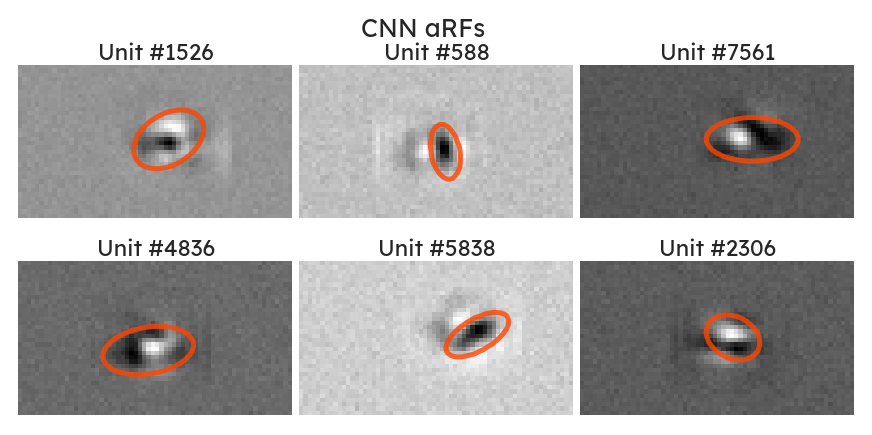

In [104]:
plot_aRFs(
    aRFs=cnn_results["aRFs"],
    parameters=cnn_results["popts"],
    title="CNN aRFs",
    filename="plots/CNN_aRFs.svg",
)

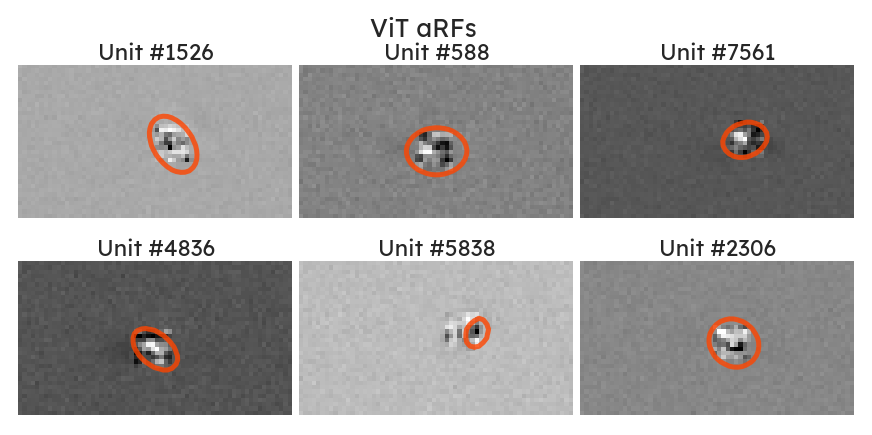

In [105]:
plot_aRFs(
    aRFs=vit_results["aRFs"],
    parameters=vit_results["popts"],
    title="ViT aRFs",
    filename="plots/ViT_aRFs.svg",
)

### Plot CNN and ViT RF centers

In [51]:
def load_centers(popts: np.ndarray):
    x, y = popts[:, 1], popts[:, 2]
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]
    x = x[np.where(x < IMAGE_SIZE[2])]
    y = y[np.where(y < IMAGE_SIZE[1])]
    return x, y

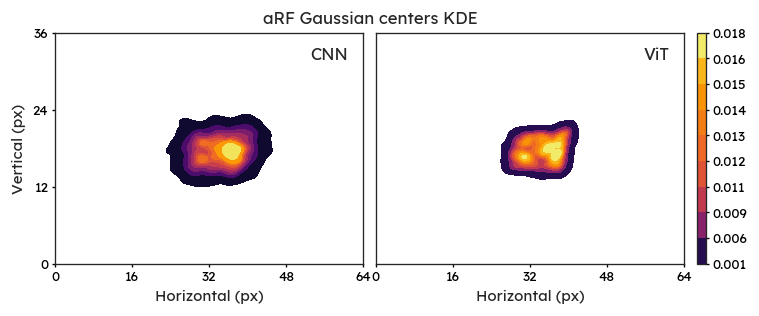

In [99]:
cnn_x, cnn_y = load_centers(cnn_results["popts"])
vit_x, vit_y = load_centers(vit_results["popts"])

tick_fontsize, label_fontsize, title_fontsize = 8, 9, 10
figure, axes = plt.subplots(
    nrows=1,
    ncols=3,
    gridspec_kw={"wspace": 0.06, "hspace": 0.0, "width_ratios": [1, 1, 0.03]},
    figsize=(7, 2.5),
    dpi=120,
)

thresh, levels = 0.01, 10
kde_kw = {
    "fill": True,
    "levels": np.linspace(thresh, 1.0, levels),
    "thresh": thresh,
    "cmap": "inferno",
}
sns.kdeplot(
    x=cnn_x,
    y=cnn_y,
    ax=axes[0],
    **kde_kw,
    label="CNN",
)
sns.kdeplot(
    x=vit_x,
    y=vit_y,
    ax=axes[1],
    **kde_kw,
    label="ViT",
    cbar=True,
    cbar_ax=axes[2],
)
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
# axes[0].set_title("CNN", fontsize=title_fontsize, y=0.975)
# axes[1].set_title("ViT", fontsize=title_fontsize, y=0.975)

x_range = np.linspace(0, IMAGE_SIZE[2], 5)
y_range = np.linspace(0, IMAGE_SIZE[1], 4)

tensorboard.set_xticks(
    axis=axes[0],
    ticks_loc=x_range,
    ticks=x_range.astype(int),
    label="Horizontal (px)",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
tensorboard.set_yticks(
    axis=axes[0],
    ticks_loc=y_range,
    ticks=y_range.astype(int),
    label="Vertical (px)",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis=axes[1],
    ticks_loc=x_range,
    ticks=x_range.astype(int),
    label="Horizontal (px)",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axes[1].set_yticks([])
axes[1].set_ylim(0, IMAGE_SIZE[1])

ticks_loc = axes[2].get_yticks()
tensorboard.set_yticks(
    axis=axes[2],
    ticks_loc=ticks_loc,
    ticks=[f"{tick:.03f}" for tick in ticks_loc],
    tick_fontsize=tick_fontsize,
)

for ax in axes:
    tensorboard.set_ticks_params(axis=ax, length=2)

pos = axes[0].get_position()
figure.suptitle(
    "aRF Gaussian centers KDE",
    fontsize=title_fontsize,
    y=pos.y1 + 0.07,
)

filename = os.path.join("plots", "aRF_centers.png")
tensorboard.save_figure(figure, filename=filename, dpi=240, close=False)

plt.show()
plt.close(figure)

### Plot CNN and ViT Gaussian standard deviations

In [109]:
def load_sigmas(popts: np.ndarray):
    x, y = popts[:, 3], popts[:, 4]
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]
    return x, y

-3.6151114 -3.7427905


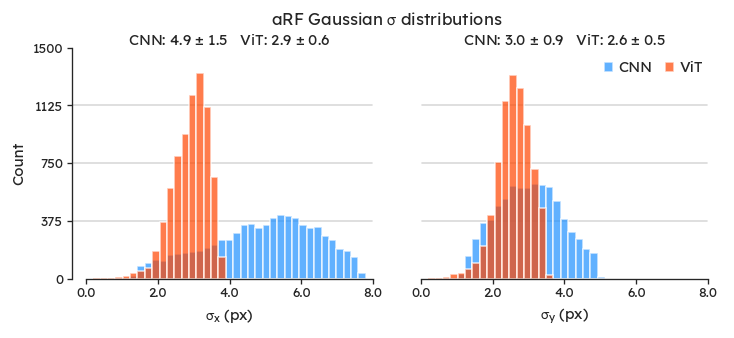

In [113]:
cnn_sigma_x, cnn_sigma_y = load_sigmas(cnn_results["popts"])
vit_sigma_x, vit_sigma_y = load_sigmas(vit_results["popts"])

tick_fontsize, label_fontsize, title_fontsize = 8, 9, 10
figure, axes = plt.subplots(
    nrows=1,
    ncols=2,
    gridspec_kw={"wspace": 0.06, "hspace": 0.0},
    figsize=(7, 2.5),
    dpi=120,
)
alpha = 0.7
x_max = 8
y_max = 1500
bins = np.linspace(0, x_max, 40)

axes[0].hist(cnn_sigma_x, bins=bins, alpha=alpha, color="dodgerblue", label="CNN")
axes[0].hist(vit_sigma_x, bins=bins, alpha=alpha, color="orangered", label="ViT")

axes[1].hist(cnn_sigma_y, bins=bins, alpha=alpha, color="dodgerblue", label="CNN")
axes[1].hist(vit_sigma_y, bins=bins, alpha=alpha, color="orangered", label="ViT")

x_range = np.linspace(0, x_max, 5)
y_range = np.linspace(0, y_max, 5)

tensorboard.set_xticks(
    axis=axes[0],
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label=r"$\sigma_x$ (px)",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
tensorboard.set_yticks(
    axis=axes[0],
    ticks_loc=y_range,
    ticks=y_range.astype(int),
    label="Count",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis=axes[1],
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label=r"$\sigma_y$ (px)",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axes[1].set_yticks([])
axes[1].set_ylim(0, y_max)

sns.despine(ax=axes[0], top=True, right=True, trim=True)
sns.despine(ax=axes[1], top=True, right=True, left=True, trim=True)

# plot y-axis grid lines
for y_value in y_range:
    if 0 < y_value < y_max:
        axes[0].axhline(
            y_value, xmax=0.95, color="gray", alpha=0.3, linewidth=1, zorder=0
        )
        axes[1].axhline(
            y_value,
            xmin=0.05,
            xmax=0.95,
            color="gray",
            alpha=0.3,
            linewidth=1,
            zorder=0,
        )


title1 = rf"CNN: {np.mean(cnn_sigma_x):.01f} $\pm$ {np.std(cnn_sigma_x):.01f}   "
title1 += rf"ViT: {np.mean(vit_sigma_x):.01f} $\pm$ {np.std(vit_sigma_x):.01f}"
axes[0].set_title(title1, fontsize=label_fontsize, pad=0)


title2 = rf"CNN: {np.mean(cnn_sigma_y):.01f} $\pm$ {np.std(cnn_sigma_y):.01f}   "
title2 += rf"ViT: {np.mean(vit_sigma_y):.01f} $\pm$ {np.std(vit_sigma_y):.01f}"
axes[1].set_title(title2, fontsize=label_fontsize, pad=0)

axes[1].legend(
    loc="upper right",
    bbox_to_anchor=(0.98, 1.0),
    ncols=2,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=0.85,
    fontsize=label_fontsize,
)

pos = axes[0].get_position()
figure.suptitle(
    r"aRF Gaussian $\sigma$ distributions",
    fontsize=title_fontsize,
    y=pos.y1 + 0.12,
)

tensorboard.save_figure(
    figure, filename=os.path.join("plots", "aRF_sigmas.png"), dpi=240, close=False
)

plt.show()
plt.close(figure)